# Dataset
We are going to use python and further libraries to analyse the sentiment Imdb movie reviews, we are going to use a pre-constructed annotated dataset that contains 25 000 rows.

OK, Let's take a look at our data by defining a function that loads the training data and extracts the two columns we need: Sentiment and Text.

In [913]:
import pandas as pd

In [914]:
def ingest_train():
    data = pd.read_csv('./with_roots.csv', encoding='utf-8', sep='\t')
    data = data[data.sentiment.isnull() == False]
    data['sentiment'] = data['sentiment'].map(int)
    data = data[data['tokens'].isnull() == False]
    data['tokens'] = data['tokens'].map(eval)
    data = data[data.roots.isnull() == False]
    data['roots'] = data['roots'].map(bool)
    data.reset_index(inplace=True)
    data.drop('index', axis=1, inplace=True)
    data.drop('id', axis=1, inplace=True)
    data = data[data['roots'] == True]
    return data

In [915]:
train = ingest_train()

In [916]:
train.describe()

,sentiment,words
count,2731.000000,2731.000000
mean,-0.007323,15.909557
std,0.579204,9.426186
min,-1.000000,2.000000
25%,0.000000,9.000000
50%,0.000000,14.000000
75%,0.000000,21.000000
max,1.000000,80.000000


In [917]:
train.head()

,tokens,sentiment,words,roots
20907,"[słodko, owocowego]",0,2,True
21234,"[więc, ,]",0,2,True
21310,"[woskach, babeczkach]",0,2,True
21620,"[głównie, .]",0,2,True
21638,"[jestem, oniemiała]",1,2,True


# Data Preparation
Now, It looks like it’s time for some cleaning!

Let's first define data cleaning function, an then apply it to the whole dataset. This function remove URL, remove HTML tags, handle negation words which are splited into two parts, convert the words to lower cases, remove all non-letter characters. These elements are very common and they do not provide enough semantic information for the task.

In [918]:
patterns_ = {"wi - fi": "wifi",
             "\d+zl": "zł",
#              "al a": "ala",
#              "be dę": "będę",
#              "ce": " ",
#              "ch": " ",
#              "em": " ",
#              "eś": " ",
#              "fi": " ",
#              "simpl ic": "simplic",
#              "anro id a": "androida",
#              "ik": " ",
#              "check in": "checkin",
#              "ka": " ",
#              "ck Euphoria": "ckEuphoria", "ck in 2u for Men": "ckin2uforMen"
            }
word_change_pattern = re.compile(r'\b(' + '|'.join(patterns_.keys()) + r')\b')

In [919]:
def data_cleaner(text):
    try:
        text_for_cleaning = " ".join(text)
        lower_case = text_for_cleaning.lower()
        pat_handled = word_change_pattern.sub(lambda x: patterns_[x.group()], lower_case)
        letters_only = re.sub(
            "[^AaĄąBbCcĆćDdEeĘęFfGgHhIiJjKkLlŁłMmNnŃńOoÓóPpQqRrSsŚśTtUuVvWwYyZzŹźŻż]", 
            " ", 
            pat_handled)
        tokens = tokenizer.tokenize(letters_only)
        return tokens
    except:
        return 'NC'

In [920]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

def post_process(data, n=1000000):
    data = data.head(n)
    data['tokens'] = data['tokens'].progress_map(data_cleaner)  
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data

In [921]:
train = post_process(train)

progress-bar: 100%|██████████| 2731/2731 [00:00<00:00, 48654.35it/s]


In [922]:
train.head()

,tokens,sentiment,words,roots
0,"[słodko, owocowego]",0,2,True
1,[więc],0,2,True
2,"[woskach, babeczkach]",0,2,True
3,[głównie],0,2,True
4,"[jestem, oniemiała]",1,2,True


In [923]:
two_letter_words = {}

def two_letters(tokens):
    tl_words = [x for x in tokens if len(x) == 2]
    for w in tl_words:
        if w not in two_letter_words:
            two_letter_words[w] = 1
        else:
            two_letter_words[w] += 1
    

In [924]:
train['tokens'].map(two_letters)
print(sorted(list(two_letter_words)))
print(two_letter_words)
print(sum(two_letter_words.values()))

['al', 'aż', 'be', 'bo', 'by', 'ce', 'ch', 'ci', 'ck', 'co', 'cv', 'da', 'di', 'do', 'dę', 'em', 'eś', 'go', 'ic', 'id', 'ii', 'ik', 'im', 'in', 'iż', 'ja', 'je', 'ją', 'ka', 'ks', 'ku', 'kę', 'la', 'ma', 'me', 'mi', 'ml', 'mm', 'ms', 'mu', 'my', 'na', 'ne', 'no', 'np', 'nr', 'od', 'of', 'ok', 'on', 'ot', 'ow', 'pi', 'po', 'pt', 'rl', 'ro', 'sa', 'se', 'si', 'sy', 'są', 'ta', 'te', 'tj', 'to', 'tu', 'tą', 'tę', 'up', 'we', 'wg', 'ww', 'wy', 'za', 'ze', 'zy', 'zę', 'zł', 'ów', 'św', 'że']
{'to': 545, 'go': 81, 'do': 403, 'co': 142, 'są': 144, 'ma': 175, 'za': 146, 'aż': 15, 'na': 765, 'po': 219, 'od': 91, 'mi': 140, 'em': 103, 'no': 26, 'je': 35, 'ok': 24, 'ta': 42, 'tą': 25, 'tu': 26, 'ja': 34, 'mu': 23, 'że': 299, 'se': 6, 'bo': 118, 'te': 29, 'tę': 9, 'ml': 12, 'im': 21, 'np': 5, 'wg': 3, 'we': 6, 'on': 12, 'si': 1, 'up': 6, 'ze': 101, 'ów': 1, 'ją': 28, 'ch': 3, 'by': 70, 'ku': 3, 'pi': 3, 'my': 1, 'eś': 1, 'sy': 1, 'zy': 1, 'wy': 1, 'iż': 9, 'ck': 2, 'in': 2, 'ne': 3, 'da': 4, 'tj'

# Data visualization
Before proceeding to the classification step, let's do some visualization of our textual data. the words cloud is a best choice for this matter, it is a visual representation of text data. It displays a list of words, the importance of each beeing shown with font size or color. This format is useful for quickly perceiving the most prominent terms.

For this data viz, we use the python library wordcloud.

Let's beging with the word cloud of negative terms.

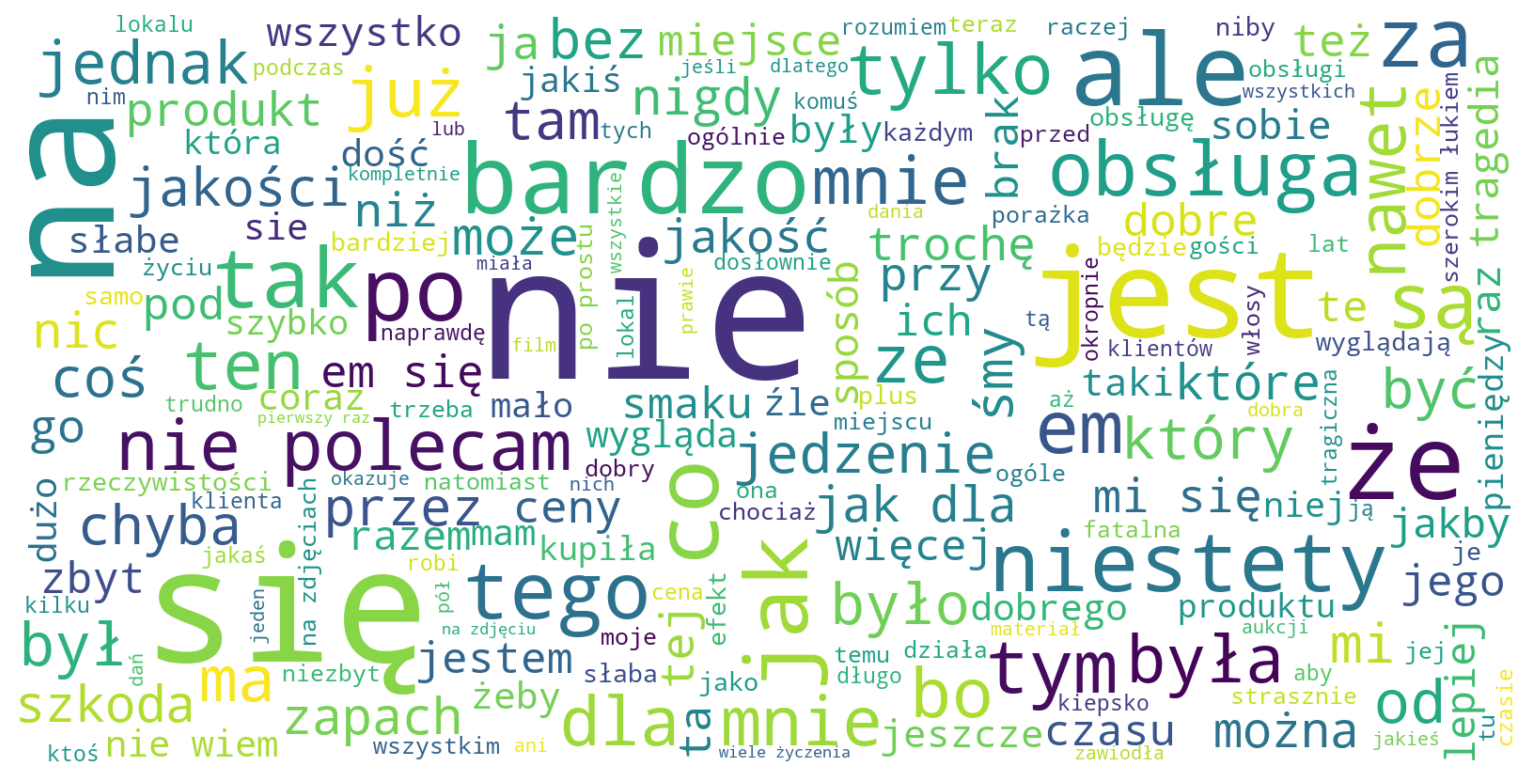

In [925]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from wordcloud import WordCloud, STOPWORDS


neg_tweets = train[train.sentiment == -1]
neg_string = []
for t in neg_tweets.tokens:
    neg_string += t
#print(neg_string)
neg_string = " ".join(neg_string)
#neg_string = pd.Series(neg_string).str.cat(sep=' ')
#print(neg_string)
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color='white').generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

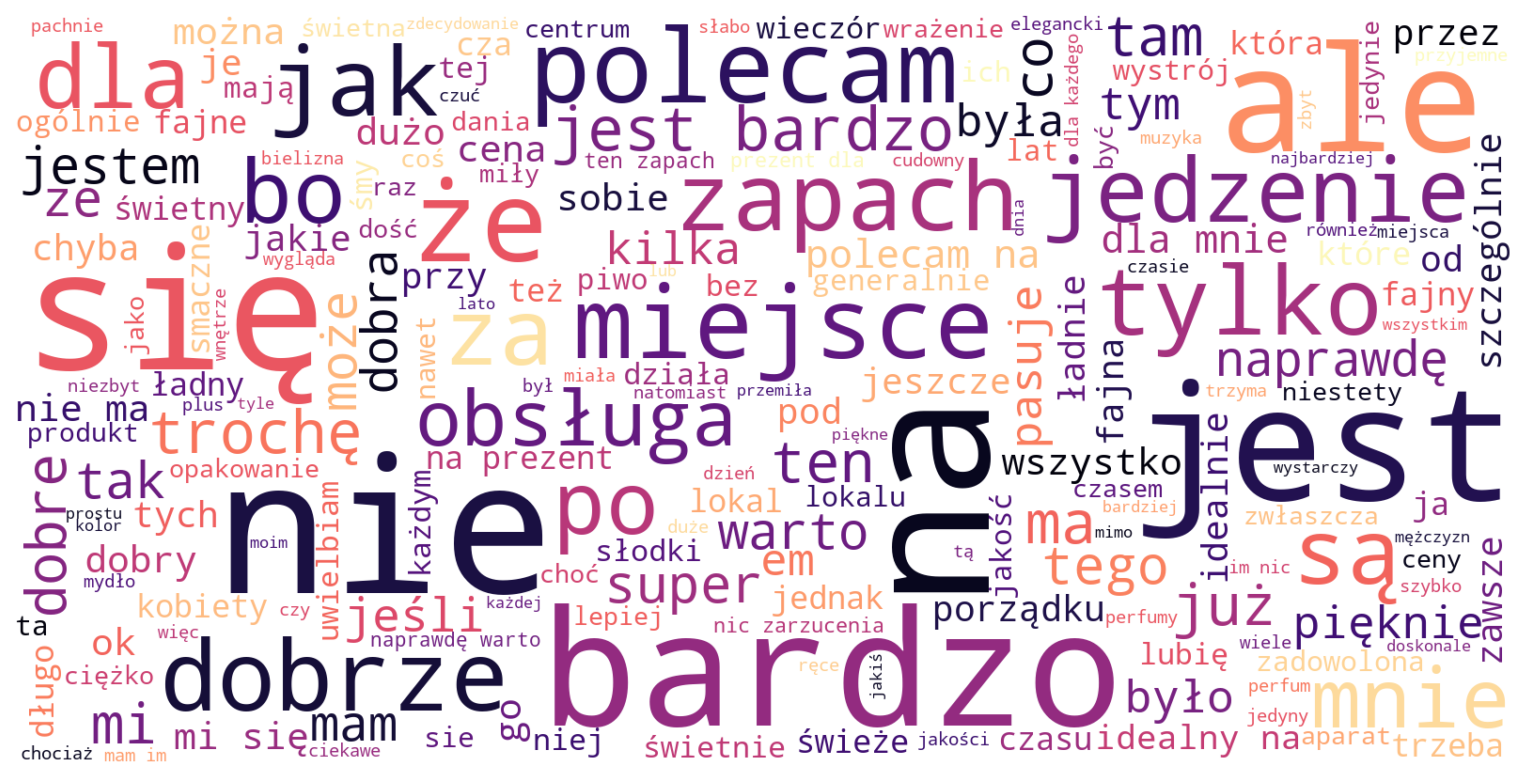

In [926]:
pos_tweets = train[train.sentiment == 1]
pos_string = []
for t in pos_tweets.tokens:
    pos_string += t
pos_string = " ".join(pos_string)
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma', background_color='white').generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

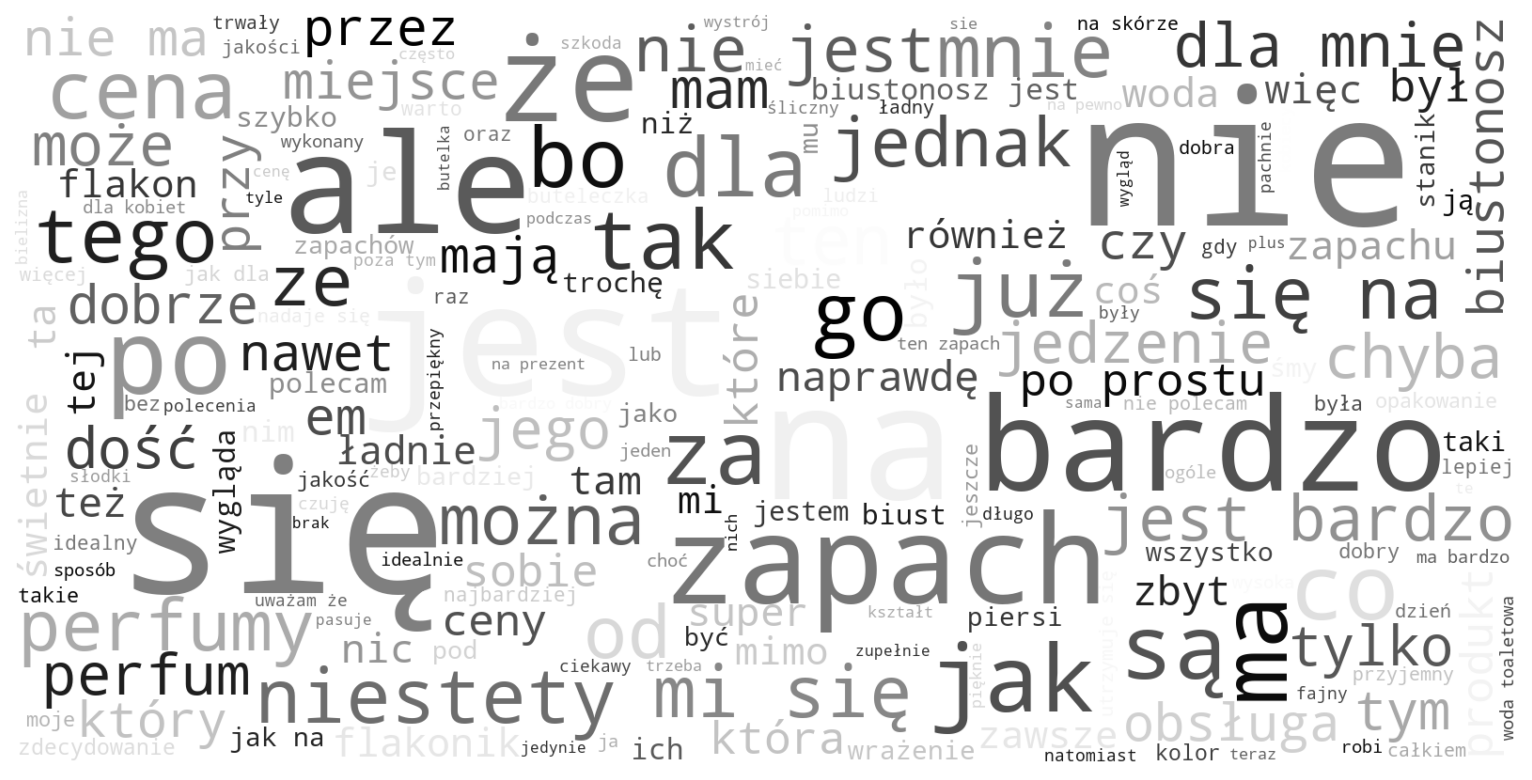

In [927]:
neutral_tweets = train[train.sentiment == 0]
neutral_string = []
for t in neutral_tweets.tokens:
    neutral_string += t
neutral_string = " ".join(neutral_string)
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='gray', background_color='white').generate(neutral_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

We can see some netural words in big size, “film”,”movie”,"character", but words like “good”, “love”, “great” are relevant for positive words and "bad', "little" for negative words.

# Building the models
Before proceeding to the training phase, let's split our data into training and validation set.

In [928]:
from sklearn.preprocessing import label_binarize

train['tokens'] = train['tokens'].map(lambda x: " ".join(x))
binary_sentiment = label_binarize(train['sentiment'], classes=[-1, 0, 1])
print(binary_sentiment)

[[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]


In [1018]:
from sklearn.model_selection import train_test_split
SEED = 2000

x_train, x_test, y_train, y_test = train_test_split(train.tokens, binary_sentiment, 
                                                                test_size=.2, random_state=SEED)

x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, 
                                                                test_size=.2, random_state=SEED)
print("train: ", len(x_train), 
      ", classes: ", sum(y_train == 1),  
      ", validation: ", len(x_validation), 
      ", classes: ", sum(y_validation == 1),
      ", test: ", len(x_test))

train:  1747 , classes:  [ 304 1169  274] , validation:  437 , classes:  [ 72 294  71] , test:  547


# Features Extraction
In this part, we will use a feature extraction technique called Tfidf vectorizer of 100,000 features including up to trigram. This technique is a way to convert textual data to numeric form.

In the below function, we will use a custom function that reports validation accuracy, the average precision_recall, and the time it took to train and evaluate.

In [1015]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
n_classes = 3

def multi_class_precision_recall(y_test, y_pred):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                            y_pred[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
        y_pred.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_pred,
                                                         average="micro")
#     print('Average precision score, micro-averaged over all classes: {0:0.2f}'
#           .format(average_precision["micro"]))
#     print(precision, recall, average_precision)
    return precision["micro"], recall["micro"], average_precision["micro"]

def multi_class_roc(y_test, y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr["micro"], tpr["micro"], roc_auc["micro"]

def multi_class_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix([np.sum(np.array([-1,0,1]) * np.array(x).T) for x in y_test], 
                         [np.sum(np.array([-1,0,1]) * np.array(x).T) for x in y_pred])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = ["-1", "0", "1"],
                  columns = ["-1", "0", "1"])
    plt.figure(figsize = (5,5))
    sn.heatmap(df_cm, annot=True, fmt='f')
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

In [1016]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
import numpy as np
from time import time

def acc_summary(pipeline, x_train, y_train, x_test, y_test):
    
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
  
    #Compute the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    #Compute the precision and recall
    precision, recall, _ = multi_class_precision_recall(y_test, y_pred)
    #Compute the average precision
    average_precision = average_precision_score(y_test, y_pred)
  
    fpr, tpr, _ = multi_class_roc(y_test, y_pred)
    multi_class_confusion_matrix(y_test, y_pred)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    print ("-"*80)
    return accuracy, precision, recall, average_precision, fpr, tpr

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


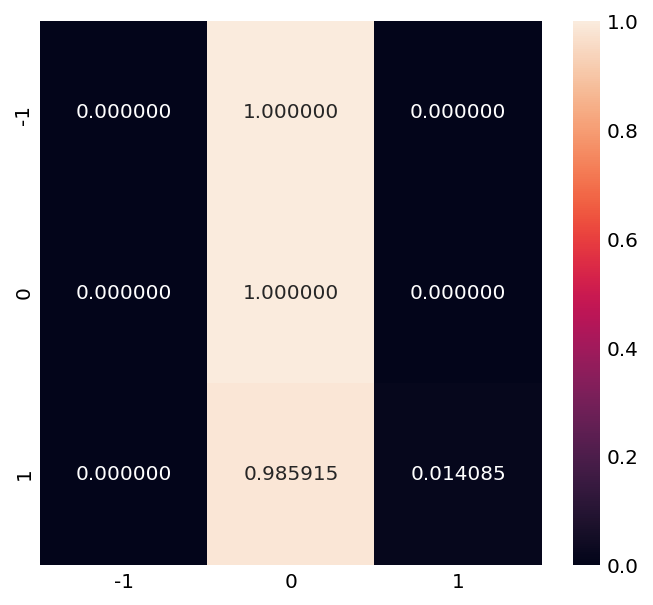

Average precision-recall score: 0.34
accuracy score: 64.99%
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


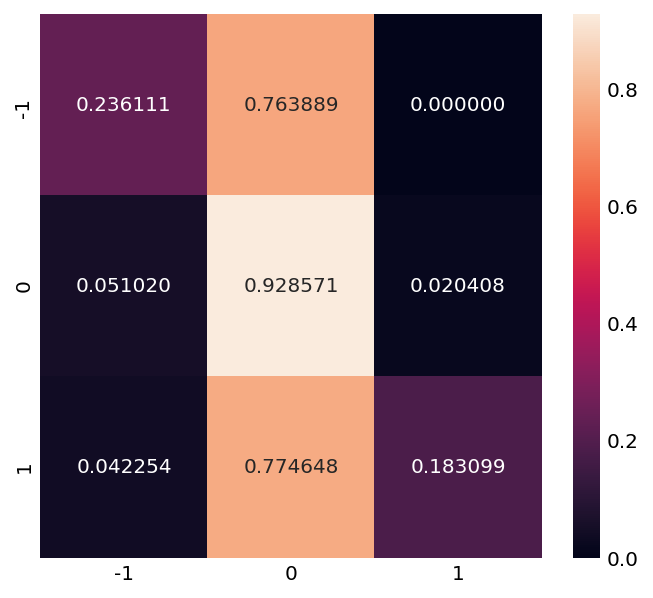

Average precision-recall score: 0.41
accuracy score: 59.27%
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                                     tol=0.0001, verbose=0),
             

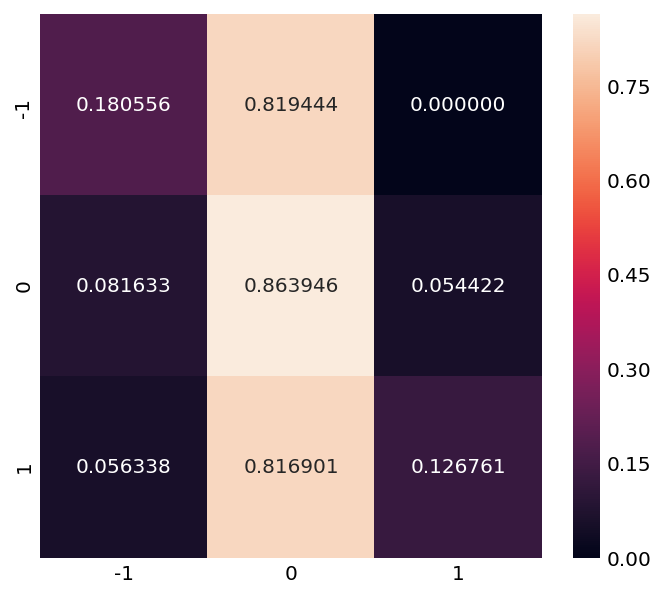

Average precision-recall score: 0.37
accuracy score: 52.63%
--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


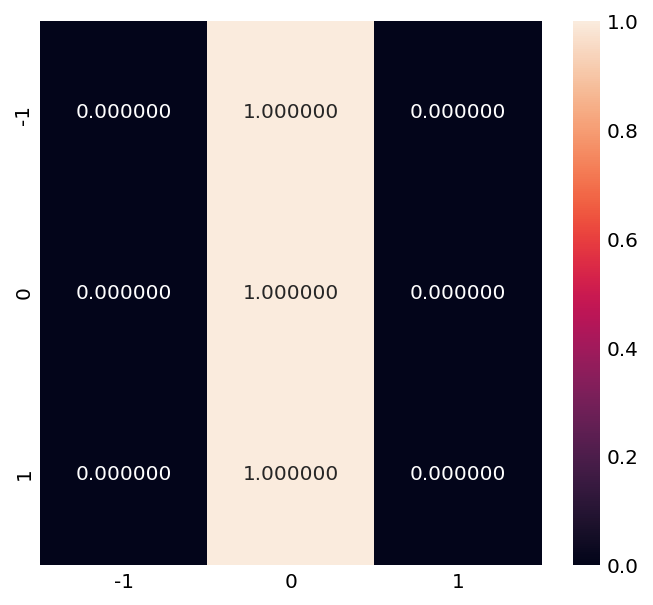

Average precision-recall score: 0.34
accuracy score: 66.59%
--------------------------------------------------------------------------------
Validation result for Bernoulli NB
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)


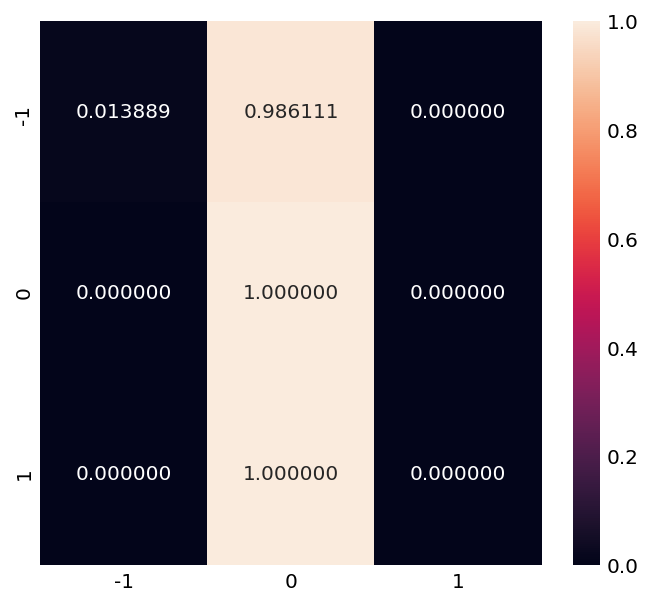

Average precision-recall score: 0.34
accuracy score: 67.51%
--------------------------------------------------------------------------------
Validation result for Ridge Classifier
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)


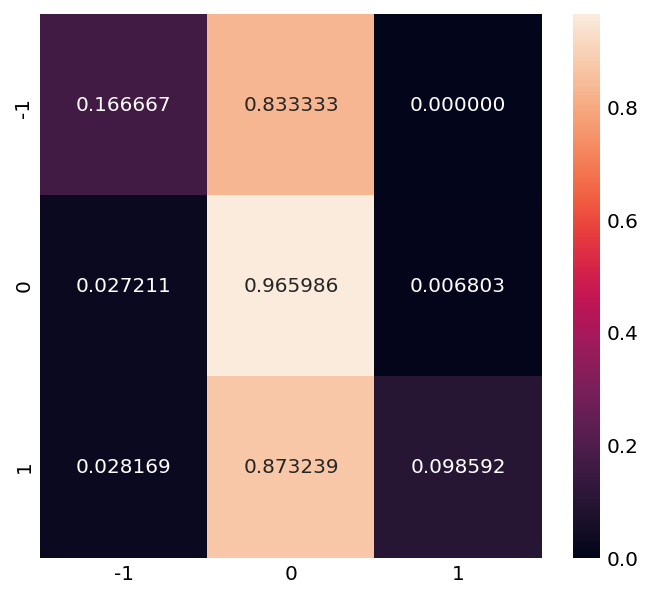

Average precision-recall score: 0.39
accuracy score: 60.18%
--------------------------------------------------------------------------------
Validation result for AdaBoost
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)


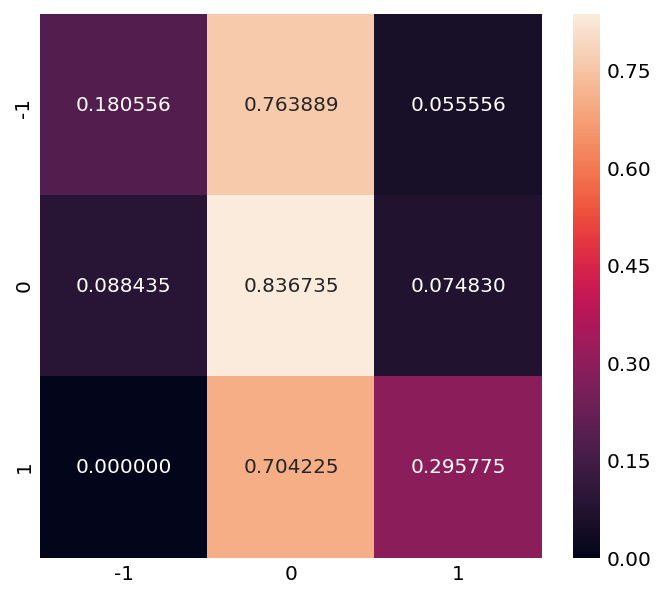

Average precision-recall score: 0.39
accuracy score: 55.15%
--------------------------------------------------------------------------------
Validation result for Perceptron
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)


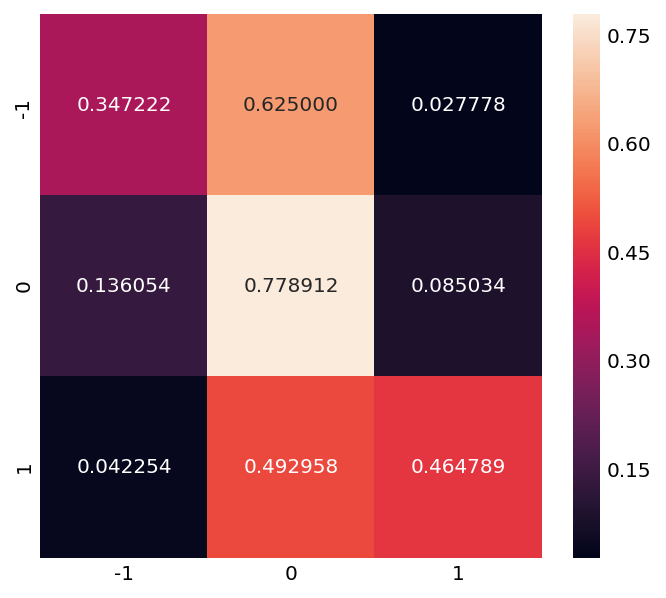

Average precision-recall score: 0.43
accuracy score: 52.63%
--------------------------------------------------------------------------------
Validation result for Passive-Aggresive
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)


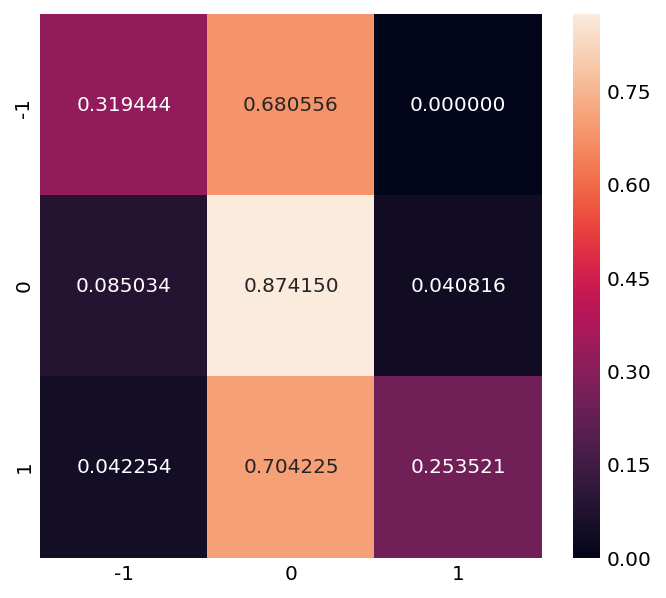

Average precision-recall score: 0.42
accuracy score: 58.81%
--------------------------------------------------------------------------------


In [1017]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, Perceptron, LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from sklearn.multiclass import OneVsRestClassifier

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier()
    ]
zipped_clf = zip(names,classifiers)

vec = TfidfVectorizer(min_df=0)

def classifier_comparator(vectorizer=vec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', OneVsRestClassifier(c))
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_acc,prec, rec, avg, fp, tp))
    return result

result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Now we plot the summary of this comparison like below, namely the accuracy of each model, their train and test time, and their average precision.

In [960]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import numpy as np

acc=[]
names = []
avg_ = []
fp_ = []
tp_ = []

for name, accuracy, prec, rec, avg, fp, tp in result:
    acc.append(accuracy*100)
    names.append(name)

    avg_.append(avg*100)
    fp_.append(fp)
    tp_.append(tp)
trace1 = go.Bar(
    x=names,
    y=acc,
    name='Accuracy percentage (%)'
)
trace3 = go.Bar(
    x=names,
    y=avg_,
    name='Average precision (%)'
)


data = [trace1, trace3]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

We can show furthermore the performance of our classifiers by using the ROC Curve technique. This curve plots two parameters: True Positive Rate, False Positive Rate

In [961]:
data = []
for i in range(0, len(names)):
    trace = go.Scatter(x=fp_[i], y=tp_[i],
                        mode='lines', 
                        name='ROC curve {}'
                               ''.format(names[i]))
    data.append(trace)
    
layout = go.Layout(title='Receiver operating characteristic ',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=data, layout=layout)

In [962]:
py.iplot(fig)